In [75]:
import numpy as np

カルマンフィルタ・予測・平滑化の概要と実装例

# はじめに

状態空間モデルにおいて状態を逐次的に推定する有名な手法の1つにカルマンフィルタというものがあります。  
カルマンフィルタなどを用いて出来る事・概要・手順・numpyを用いた行列実装をまとめてみました。

## この記事の対象としている人

* 確率分布の計算はなんとなくわかる
* 状態空間の概念はなんとなくわかる
* カルマンフィルタはよく知らない
* 多次元に拡張可能な形のnumpy実装の仕方を知りたい

# カルマンフィルタで出来る事

カルマンフィルタを使うと、ノイズ混じりの観測データから、観測ノイズを取り除いた状態を逐次推定できます。  
経済やマーケティングの文脈においては、時系列データの平滑化やトレンドの把握、少し先の予測などに使われます。

ある事象に対して、時点1から時点tまで時系列に沿って観測したデータ$y_{1:t}$があるとします。  
例えば、DAU(Daily Active User, 1日あたりにログインしたユーザー数)を想定します。  
DAUが以下のように分解出来るとします。

$$
DAU = 状態(サービス内要因, サービス魅力度など) + 観測誤差(サービス外要因, 曜日変動やノイズなど) \\
観測誤差(サービス外要因) \sim N(0, \Sigma) \\
$$

DAUの監視を通じて知りたいのは、時点tにおけるサービスの魅力度を表す状態$x_t$です。しかし、状態$x_t$そのものを直接観測する事は出来ず、観測出来るDAUはサービス外の要因が混じっています。なので、DAU観測データ$y_{1:t}$からサービス外の要因を取り除き、状態$x_t$を推定したいです。  

そこで、フィルタリングや予測、平滑化を行います。  

## フィルタリング、予測、平滑化の違い

時点1から時点tまでの観測データ$y_{1:t}$を元に、ある時点の状態$x_{t'}$を推定します。つまり、$p(x_{t'} | y_{1:t})$を求めます。  
より正確には、観測データが手元にあるときの時点tの状態$x_t$確率分布$p(x_{t'} | y_{1:t})$を求め、その平均や分散を求めます。  
ここで、  
* t' < t, つまり時点tまでの観測値を元に過去の時点の状態$x_{t'}$を推定する場合、平滑化
* t' = t, つまり時点tまでの観測値を元に現在の時点の状態$x_{t'}$を推定する場合、フィルタリング
* t' > t, つまり時点tまでの観測値を元に未来の時点の状態$x_{t'}$を推定する場合、予測  

という違いがあります。  
例えば、過去のトレンドを知りたいときは平滑化を行ってもよいですし、現在のトレンドをリアルタイムに知りたければ、最新時点のデータが入ってくる度にフィルタリングを行えばよいでしょう。

# カルマンフィルタについて

カルマンフィルタ、カルマン予測、カルマン平滑化の順に説明します。

## 前提

まず、以下のような状態空間モデルを想定します

$$
状態方程式: x_t = G_t x_{t-1} + w_t \\
観測方程式: y_t = F_t x_t + v_t \\
状態ノイズ: w_t \sim N(0, W_t) \\
観測ノイズ: v_t \sim N(0, V_t)
$$

$x_t, w_t$: p×1ベクトル  
$G_t, W_t$: p×p行列  
$F_t$: 1×pベクトル  
$y_t, v_t, V_t$: スカラー

状態$x$は、時点tが増えるにつれ係数$G$がかかり、状態が遷移していきます。  
状態が遷移する度に、正規分布に従うノイズ$w$が混ざります。  
時点tの観測値$y_t$は、観測方程式に従って求められます。  
観測値$y_t$には、正規分布に従う観測ノイズ$v$が混ざります。

$G_t, F_t, W_t, V_t$は既知であるとします。

## カルマンフィルタの概要

カルマンフィルタは、時点tまでの観測値$y_{1:t}$から時点tの状態$x_t$を逐次的に効率よく求める手法です。  
観測値から観測ノイズを取り除いた状態を推定するので、フィルタリングと呼ばれます。

時点tまでの観測値$y_{1:t}$の情報を元に時点tの状態$x_t$を推測するフィルタリング分布$p(x_t | y_{1:t})$を逐次的に求めたいです。  
具体的には、時点毎のフィルタリング分布を仮定し、そのパラメータを逐次的に求めたいです。  
そのために、以下の3つの分布を設定します。  
$$
フィルタリング分布: p(x_t | y_{1:t}) = N(m_t, C_t) \\
一期先予測分布: p(x_t | y_{1:1-t}) = N(a_t, R_t) \\
一期先予測尤度: p(y_t | y_{1:t-1}) = N(f_t, Q_t) \\
$$  

フィルタリング分布は時点tまでの観測値$y_{1:t}$を元に時点tの状態$x_t$を発生させる分布  
一期先予測分布は時点t-1までの観測値$y_{1:t-1}$を元に時点tの状態$x_t$を予測する分布  
一期先予測尤度は時点t-1までの観測値$y_{1:t-1}$を元に時点tの観測値$y_t$を予測する関数  

一期先予測分布$p(x_t | y_{1:t-1})$は、観測値$y_t$を観測する前に予測したフィルタリング分布$p(x_t | y_{1:t})$のようなものです。  
フィルタリング分布と一期先予測分布はどちらも$x_t$を発生させる確率分布になっています。  
最後の関数が尤度と名付いているのは、恐らくこの関数が観測された$y_{1:t}$から尤もらしいパラメータ$m_t, C_t$を推測するために使われるからだと思われます。  
確率"分布"(確率密度関数)は固定したパラメータからある値が発生する確率を求めるのに対し、"尤度"(尤度関数)は観測されたデータ(固定された値)を発生させたパラメータがある値だとどれくらい尤もらしいかを返す関数です。

時点tにおけるパラメータ$\Theta_t = \{ m_t, C_t, a_t, R_t, f_t, Q_t \}$を、時点t-1のフィルタリング分布パラメータ$m_{t-1}, C_{t-1}$と観測値$y_t$を用いて求めます。

## カルマンフィルタの手順  

過去の観測値$y_{1:t-1}$から1期先予測分布(予測値に基づくフィルタリング分布)を計算して、その後に観測された$y_t$を用いて1期先予測分布のパラメータを修正していくイメージです  

1期先予測分布$p(x_t|y_{1:t-1})$を計算・予測  
↓  
データ$Y_t=y_t$を観測  
↓  
$y_t$の情報を元にフィルタリング分布$p(x_t|y_{1:t})$へ修正  

この計算を観測したい時点まで繰り返します。

初期状態のフィルタリング分布のパラメータ$m_0, C_0$を設定します  

以下の計算をT回繰り返します  

1. 時点tの一期先予測分布$p(x_t | y_{1:t-1})$のパラメータ  
$$
a_t = G_t m_{t-1} \\
R_t = G_t C_t G_t^T + W_t
$$
2. 時点tの一期先予測尤度$p(y_t | y_{1:t-1})$のパラメータ  
$$
f_t = F_t a_t \\
Q_t = F_t R_t F_t^T + V_t
$$
3. 時点tのカルマンゲイン  
$$
K_t = R_t F_t^T Q_t^{-1}
$$
4. 時点tの状態($x_t$を発生させるフィルタリング分布のパラメータ)の更新  
$$
m_t = a_t + K_t(y_t - f_t) \\
C_t = (I - K_t F_t) R_t
$$

In [76]:
# コードにするとこんな感じ
def kalman_filter(m, C, y, G=G, F=F, W=W, V=V):
    """
    Kalman Filter
    m: 時点t-1のフィルタリング分布の平均
    C: 時点t-1のフィルタリング分布の分散共分散行列
    y: 時点tの観測値
    """
    a = G @ m
    R = G @ C @ G.T + W
    f = F @ a
    Q = F @ R @ F.T + V
    # 逆行列と何かの積を取る場合は、invよりsolveを使った方がいいらしい
    K = (np.linalg.solve(Q.T, F @ R.T)).T
    # K = R @ F.T @ np.linalg.inv(Q)
    m = a + K @ (y - f)
    C = R - K @ F @ R
    return m, C

## カルマン予測の概要・手順

カルマン予測は、t+k時点予測分布$p(x_{t+k} | y_{1:t})$を求める手法です。  
基本的な概念はカルマンフィルタと変わりません。  
カルマンフィルタは  
1. 一期先予測分布$p(x_t | y_{t-1})$を計算
2. データ$y_t$を元にフィルタリング分布$p(x_t|y_{1:t})$へ修正

という流れを辿っていましたが、未来のデータは観測出来ません。そこで  

1. 最新時点tのフィルタリング分布$p(x_t | y_{1:t})=p(x_{t+0} | y_{1:t})$を準備、時点tにおける0期先予測分布とする
2. $p(x_t | y_{1:t})$を用いてt+1時点の一期先予測分布$p(x_{t+1} | y_{1:t})$を計算
3. $p(x_{t+1} | y_{1:t})$を用いてt+2時点の一期先予測分布$p(x_{t+2} | y_{1:t})$を計算  
...  

というように、観測データによる修正をせずひたすら予測分布の計算を繰り返します。カルマンフィルタと同じ計算式です。

以下の計算をT回繰り返します  

1. 時点tの一期先予測分布$p(x_t | y_{1:t-1})$のパラメータ  
$$
a_t = G_t m_{t-1} \\
R_t = G_t C_t G_t^T + W_t
$$

In [77]:
# 一期先予測分布を連続して求めるだけ
def kalman_prediction(a, R, G=G, W=W):
    """
    Kalman prediction
    """
    a = G @ a
    R = G @ R @ G.T + W
    return a, R

## カルマン平滑化の概要・手順

カルマン平滑化は、時点tの平滑化分布
$$
p(x_t | y_{1:T}) = N(s_t, S_t)
$$を求める手法です。(t < T)  
カルマンフィルタを時点Tまで計算したとします。  
カルマン平滑化は、時点tのフィルタリング分布$p(x_t | y_{1:t})$を、時点t+1の平滑化分布$p(x_{t+1} | y_{1:T})$で補正します。  
これにより、トレンドはより滑らかになります。  

手順(RTSアルゴリズム)  

0. 時点t+1での平滑化分布: $s_{t+1}, S_{t+1}$を準備(t=Tのときは時点tのフィルタリング分布を使用)
1. 時点tの平均化利得を計算
$$
A_t = C_t G_{t+1}^T R_{t+1}^{-1}
$$
2. 時点tの平滑化分布のパラメータを計算
$$
s_t = m_t + A_t(s_{t+1} - a_{t+1}) \\
S_t = C_t + A_t(S_{t+1} - R_{t+1}A_t^T)
$$

In [78]:
# カルマン平滑化  
# 固定区間平滑化を行う  
# 時点Tまでのカルマンフィルタリングが一旦完了しているものとする  
# aとRの計算は、カルマンフィルタリングの計算時に格納したものを使った方が、計算効率は良さそう
def kalman_smoothing(s, S, m, C, G=G, W=W):
    """
    Kalman smoothing
    """
    # 1時点先予測分布のパラメータ計算
    a = G @ m
    R = G @ C @ G.T + W
    # 平滑化利得の計算
    A = np.linalg.solve(R, C @ G.T)
    # A = C @ G.T @ np.linalg.inv(R)
    # 状態の更新
    s = m + A @ (s - a)
    S = C + A @ (S - R) @ A.T
    return s, S

# 実装

## ライブラリのインポート

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook as tqdm

np.random.seed(1234)
pd.set_option('display.max_columns', None)
sns.set_style('darkgrid')

%matplotlib inline

## 仮想データ

一番簡単な例として、ランダムウォークを想定します。  
これは、ローカルモデルの一種です。

$$
x_t = x_{t-1} + w_t \\
y_t = x_t + v_t \\
w_t \sim N(0, 1) \\
v_t \sim N(0, 10) \\
$$

観測時点Tは50, 予測時点は5, 初期状態は100とします

In [80]:
G = np.array([[1]])
F = np.array([[1]])
W = np.array([[1]]) # 恣意的に与える必要がある
V = np.array([[10]]) # 上に同じ
T = 100
K = 5
x0 = 100

w = np.random.multivariate_normal(np.zeros(1), W, T+K)
v = np.random.multivariate_normal(np.zeros(1), V, T+K)
x = np.zeros(T+K)
y = np.zeros(T+K)

x[0] = x0 + w[0]
y[0] = x[0] + v[0]
for t in range(1, T+K):
    x[t] = x[t-1] + w[t]
    y[t] = x[t] + v[t]

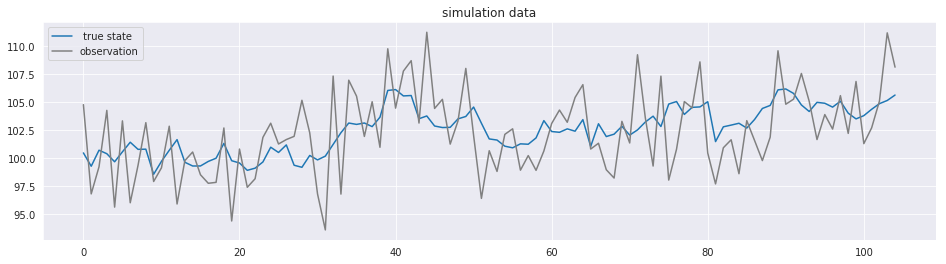

In [99]:
fig, ax = plt.subplots(figsize=(16, 4))
sns.lineplot(np.arange(T+K), x, ax=ax, label=" true state")
sns.lineplot(np.arange(T+K), y, color="gray", ax=ax, label="observation")
ax.set_title("simulation data")
ax.legend()
plt.show()

## パラメータ設定

In [82]:
# 初期状態のフィルタリング分布のパラメータ
m0 = np.array([[0]])
C0 = np.array([[1e7]])

In [83]:
# 結果を格納するarray
m = np.zeros((T, 1))
C = np.zeros((T, 1, 1))
a_pred = np.zeros((K, 1))
R_pred = np.zeros((K, 1, 1))
s = np.zeros((T, 1))
S = np.zeros((T, 1, 1))

## 実行

In [84]:
# カルマンフィルター
for t in range(T):
    if t == 0:
        m[t], C[t] = kalman_filter(m0, C0, y[t:t+1])
    else:
        m[t], C[t] = kalman_filter(m[t-1:t], C[t-1:t], y[t:t+1])

In [85]:
# カルマン予測
for t in range(K):
    if t == 0:
        a = G @ m[T-1:T]
        R = G @ C[T-1:T] @ G.T + W
        a_pred[t] = a
        R_pred[t] = R
    else:
        a_pred[t], R_pred[t] = kalman_prediction(a_pred[t-1], R_pred[t-1])

In [86]:
# カルマン平滑化
for t in range(T):
    t = T - t - 1
    if t == T - 1:
        s[t] = m[t]
        S[t] = C[t]
    else:
        s[t], S[t] = kalman_smoothing(s[t+1], S[t+1], m[t], C[t])

# 結果

$Z_{0.05/2} \fallingdotseq 1.96$より、標準偏差に1.96を掛けたものを95%区間とします。  
カルマンフィルタリング(t<=50)とカルマン予測(t>50)の結果をプロットします。

In [89]:
upper = 115
lower = 85
legend_loc = "lower left"

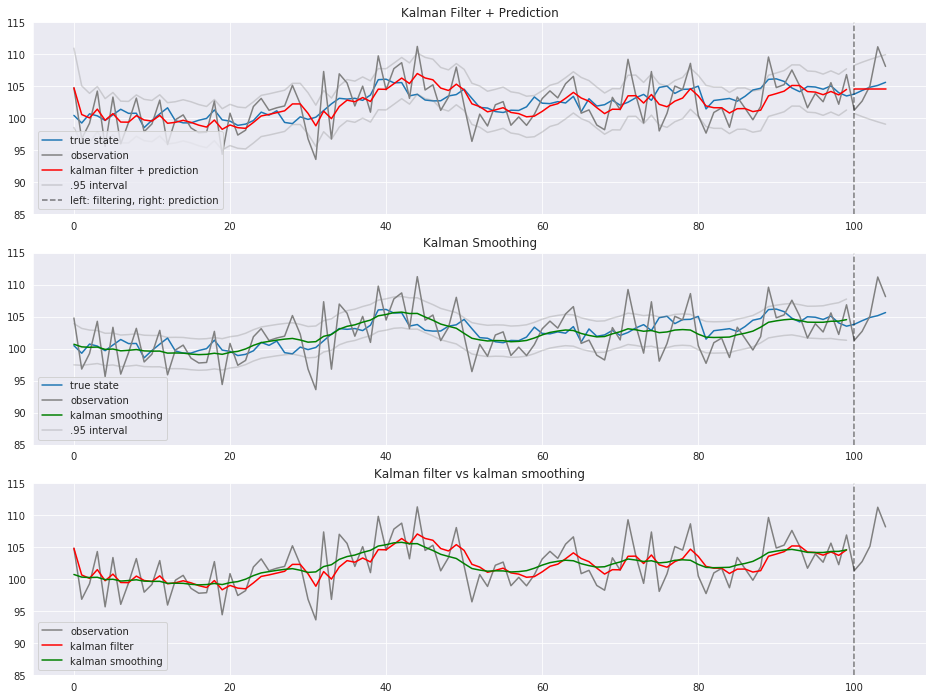

In [98]:
fig, axes = plt.subplots(nrows=3, figsize=(16, 12))
sns.lineplot(np.arange(T+K), x, ax=axes[0], label="true state")
sns.lineplot(np.arange(T+K), y, color="gray", ax=axes[0], label="observation")
sns.lineplot(np.arange(T), m.flatten(), color="red", ax=axes[0], label="kalman filter + prediction")
axes[0].plot(np.arange(T), (m - 1.96 * C[:,:,0]**(1/2)).flatten(), alpha=0.3, color='gray', label=".95 interval")
axes[0].plot(np.arange(T), (m + 1.96 * C[:,:,0]**(1/2)).flatten(), alpha=0.3, color='gray')
axes[0].plot(np.arange(T, T+K), a_pred.flatten(), color='red')
axes[0].plot(np.arange(T, T+K), (a_pred - 1.96 * R_pred[:,:,0]**(1/2)).flatten(), alpha=0.3, color='gray')
axes[0].plot(np.arange(T, T+K), (a_pred + 1.96 * R_pred[:,:,0]**(1/2)).flatten(), alpha=0.3, color='gray')
axes[0].axvline(100, color="black", linestyle="--", alpha=0.5, label="left: filtering, right: prediction")
axes[0].set_ylim(lower, upper)
axes[0].legend(loc=legend_loc)
axes[0].set_title("Kalman Filter + Prediction")

sns.lineplot(np.arange(T+K), x, ax=axes[1], label="true state")
sns.lineplot(np.arange(T+K), y, color="gray", ax=axes[1], label="observation")
sns.lineplot(np.arange(T), s.flatten(), color="green", ax=axes[1], label="kalman smoothing")
axes[1].plot(np.arange(T), (s - 1.96 * S[:,:,0]**(1/2)).flatten(), alpha=0.3, color='gray', label=".95 interval")
axes[1].plot(np.arange(T), (s + 1.96 * S[:,:,0]**(1/2)).flatten(), alpha=0.3, color='gray')
axes[1].axvline(100, color="black", linestyle="--", alpha=0.5, )
axes[1].set_ylim(lower, upper)
axes[1].legend(loc=legend_loc)
axes[1].set_title("Kalman Smoothing")

# sns.lineplot(np.arange(T+K), x, ax=axes[2], label="true state")
sns.lineplot(np.arange(T+K), y, color="gray", ax=axes[2], label="observation")
sns.lineplot(np.arange(T), m.flatten(), color="red", ax=axes[2], label="kalman filter")
sns.lineplot(np.arange(T), s.flatten(), color="green", ax=axes[2], label="kalman smoothing")
axes[2].axvline(100, color="black", linestyle="--", alpha=0.5)
axes[2].set_ylim(lower, upper)
axes[2].legend(loc=legend_loc)
axes[2].set_title("Kalman filter vs kalman smoothing")
plt.show()

In [96]:
print("カルマンフィルタリングの分散の平均: {:.3f}".format(C.mean()))
print("カルマン平滑化の分散の平均: {:.3f}".format(S.mean()))

カルマンフィルタリングの分散の平均: 2.823
カルマン平滑化の分散の平均: 1.611


青が真の状態、グレーが観測値、赤がカルマンフィルタ、緑がカルマン平滑化です。  
カルマンフィルタ(赤)やカルマン平滑化(緑)と真の状態(青)がそれなりに近しい動き方をしていることがわかります。  
観測誤差をある程度取り除いて状態を推定できました。  
カルマンフィルタと比べ、カルマン平滑化の方が分散が小さくなっています。  
カルマン予測は時点を追うごとに分散が大きくなっています。  
過去と現在の情報から状態を推測するカルマンフィルタに比べ、カルマンフィルタの結果を1期先の平滑化分布で補正するカルマン平滑化の方が、よりなだらかです。

~~いかがでしたでしょうか~~

# まとめ

* カルマンフィルタは時点tまでの観測値$y_{1:t}$から時点tの状態$x_t$を発生させるフィルタリング分布$p(x_t|y_{1:t})$を求める手法
* 観測誤差のノイズを取り除いて、状態を推定することができる
* pythonで実装してみた

TO DO  
もっと複雑なモデルに対する適用